<a href="https://colab.research.google.com/github/yashraj01-se/Pytorchrepo/blob/main/Saliency_map%2Bguided_Backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

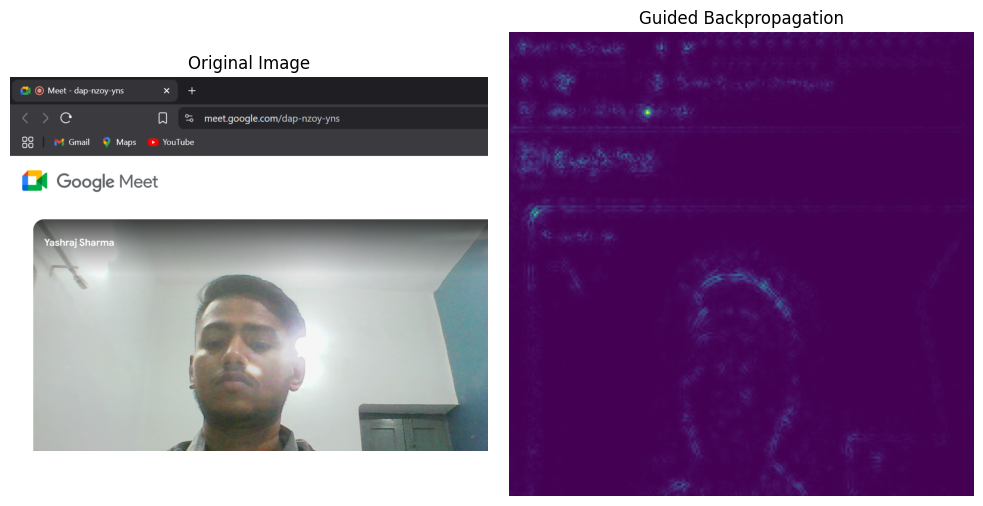

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Custom ReLU with Guided Backprop
class GuidedReLU(nn.Module):
    def forward(self, input):
        return torch.relu(input)

    def backward_hook(self, module, grad_input, grad_output):
        # Only pass positive gradients and inputs
        guided_grad_input = tuple(torch.clamp(g, min=0.0) if g is not None else None for g in grad_input)
        return guided_grad_input

# Replace all ReLU with GuidedReLU and attach hooks
def replace_relu_with_guided_relu(model):
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            guided_relu = GuidedReLU()
            model._modules[name] = guided_relu
            model._modules[name].register_backward_hook(guided_relu.backward_hook)
        else:
            replace_relu_with_guided_relu(module)

# Load a pretrained model
model = models.resnet18(pretrained=True)
model.eval()
replace_relu_with_guided_relu(model)

# Load image
img_path = '/content/Screenshot 2025-07-04 103012.png'
img = Image.open(img_path).convert('RGB')

# Preprocess
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(img).unsqueeze(0)
input_tensor.requires_grad_()  # Needed for gradient computation

# Forward
output = model(input_tensor)
pred_class = output.argmax()

# Backward
model.zero_grad()
output[0, pred_class].backward()

# Get guided gradients w.r.t. input
guided_gradients = input_tensor.grad.data.squeeze().cpu()
saliency, _ = torch.max(guided_gradients.abs(), dim=0)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Guided Backpropagation")
plt.imshow(saliency.numpy(), cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()
